In [1]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, SGDRegressor

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error  # use this instead of root_mean_squared_error
from feature_engine.timeseries.forecasting import LagFeatures
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight') 

In [2]:
import pandas as pd
train = pd.read_csv(r"F:\My_CSV_\Rossmann\train.csv", low_memory=False)
store = pd.read_csv(r"F:\My_CSV_\Rossmann\store.csv")


In [3]:
train.shape, store.shape

((1017209, 9), (1115, 10))

In [4]:
train_ = train.copy()
#train_['Date'] = pd.to_datetime(train_['Date'])
train_ = train_.drop(columns = ['Store', 'Customers', 'DayOfWeek','Open'])

In [5]:
train_['Sales'].max(), train_['Sales'].min()

(41551, 0)

In [184]:
no_sales = train_.loc[train_['Sales'] == 0, ['Sales','Date']]

In [186]:
no_sales

,Sales,Date
291,0,2015-07-31
875,0,2015-07-31
1406,0,2015-07-30
1990,0,2015-07-30
2521,0,2015-07-29
...,...,...
1017204,0,2013-01-01
1017205,0,2013-01-01
1017206,0,2013-01-01
1017207,0,2013-01-01


In [6]:
train_ = train_.loc[train_['Sales'] != 0]

In [7]:
train_ = train_.loc[train_['Sales']>=500]

In [8]:
train_['Sales'].max()

41551

In [9]:
train_.shape

(844331, 5)

In [10]:
train_.describe()

,Sales,Promo,SchoolHoliday
count,844331.000000,844331.000000,844331.000000
mean,6956.014886,0.446357,0.193579
std,3103.767963,0.497114,0.395103
min,506.000000,0.000000,0.000000
25%,4859.000000,0.000000,0.000000
50%,6369.000000,0.000000,0.000000
75%,8360.000000,1.000000,0.000000
max,41551.000000,1.000000,1.000000


In [11]:
train_

,Date,Sales,Promo,StateHoliday,SchoolHoliday
0,2015-07-31,5263,1,0,1
1,2015-07-31,6064,1,0,1
2,2015-07-31,8314,1,0,1
3,2015-07-31,13995,1,0,1
4,2015-07-31,4822,1,0,1
...,...,...,...,...,...
1016776,2013-01-01,3375,0,a,1
1016827,2013-01-01,10765,0,a,1
1016863,2013-01-01,5035,0,a,1
1017042,2013-01-01,4491,0,a,1


In [12]:
train_ = train_.set_index('Date')
train_.index = pd.to_datetime(train_.index)

In [13]:
train_.index

DatetimeIndex(['2015-07-31', '2015-07-31', '2015-07-31', '2015-07-31',
               '2015-07-31', '2015-07-31', '2015-07-31', '2015-07-31',
               '2015-07-31', '2015-07-31',
               ...
               '2013-01-01', '2013-01-01', '2013-01-01', '2013-01-01',
               '2013-01-01', '2013-01-01', '2013-01-01', '2013-01-01',
               '2013-01-01', '2013-01-01'],
              dtype='datetime64[ns]', name='Date', length=844331, freq=None)

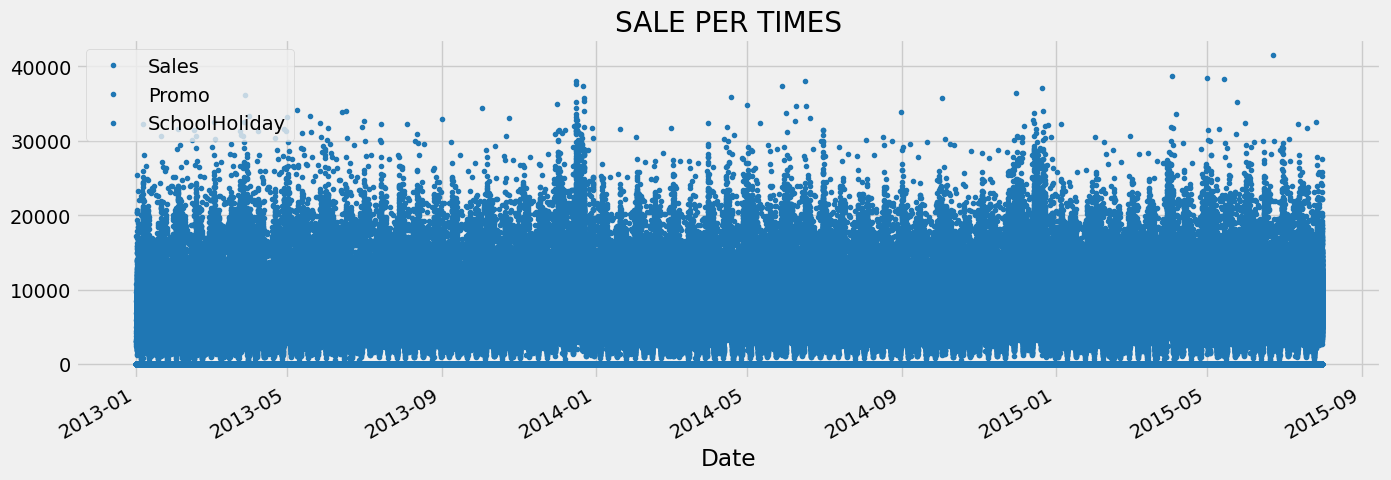

In [14]:
train_.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='SALE PER TIMES')
plt.show()

##  Outlier Analysis and removal

<Axes: ylabel='Frequency'>

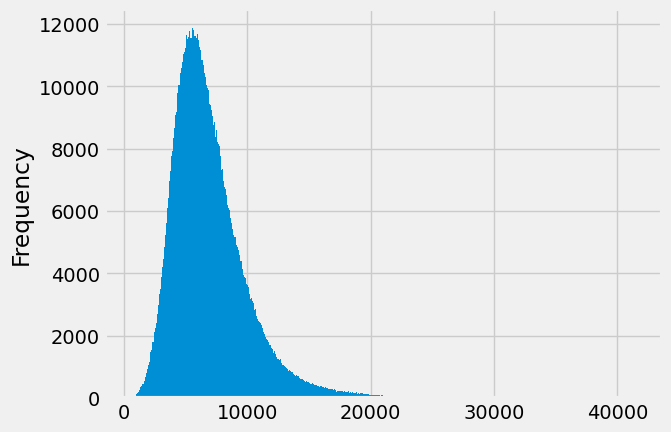

In [15]:
train_['Sales'].plot(kind='hist', bins=500)

In [16]:
train_.query('Sales <= 20000')

,Sales,Promo,StateHoliday,SchoolHoliday
Date,,,,
2015-07-31,5263,1,0,1
2015-07-31,6064,1,0,1
2015-07-31,8314,1,0,1
2015-07-31,13995,1,0,1
2015-07-31,4822,1,0,1
...,...,...,...,...
2013-01-01,3375,0,a,1
2013-01-01,10765,0,a,1
2013-01-01,5035,0,a,1


In [17]:
train_.query('Sales > 25000')

,Sales,Promo,StateHoliday,SchoolHoliday
Date,,,,
2015-07-31,25774,1,0,1
2015-07-31,25280,1,0,1
2015-07-31,27508,1,0,1
2015-07-29,25840,1,0,1
2015-07-28,25518,1,0,1
...,...,...,...,...
2013-01-08,28050,1,0,0
2013-01-07,26008,1,0,0
2013-01-07,32263,1,0,0


<Axes: title={'center': 'Outliers'}, xlabel='Date'>

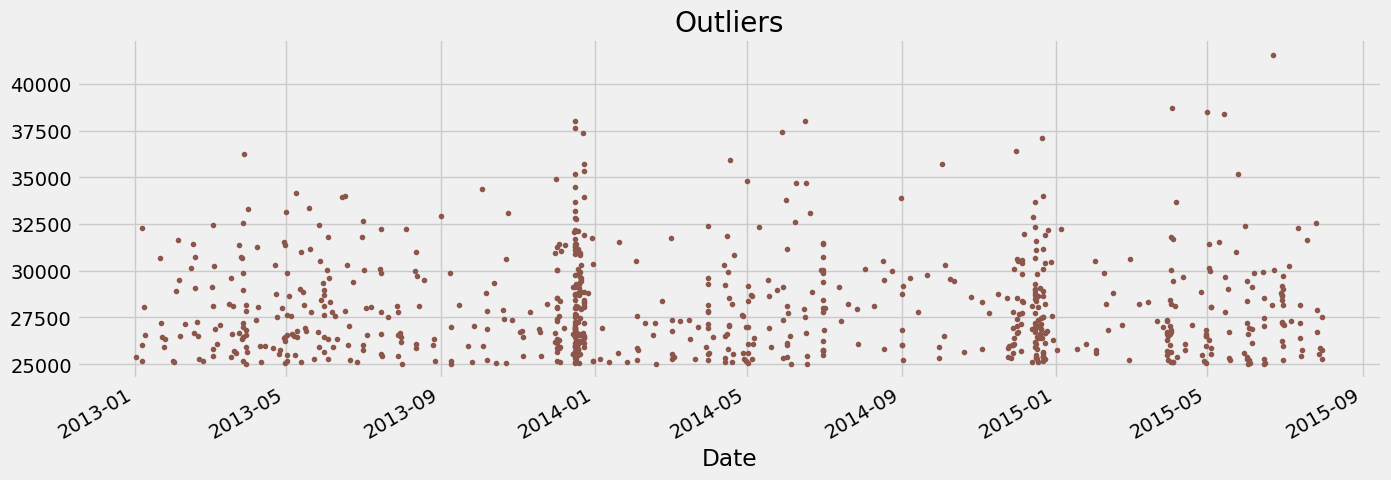

In [18]:
train_.query('Sales > 25000')['Sales'] \
    .plot(style='.',
          figsize=(15, 5),
          color=color_pal[5],
          title='Outliers')

In [19]:
train_ = train_.query('Sales <= 25000').copy()

In [20]:
train_

,Sales,Promo,StateHoliday,SchoolHoliday
Date,,,,
2015-07-31,5263,1,0,1
2015-07-31,6064,1,0,1
2015-07-31,8314,1,0,1
2015-07-31,13995,1,0,1
2015-07-31,4822,1,0,1
...,...,...,...,...
2013-01-01,3375,0,a,1
2013-01-01,10765,0,a,1
2013-01-01,5035,0,a,1


In [21]:
train_.shape

(843573, 4)

In [22]:
print(f"Total rows: {len(train_)}")


Total rows: 843573


 ## Train / Test Split

C:\ProgramData\Anaconda3\envs\ml-env\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


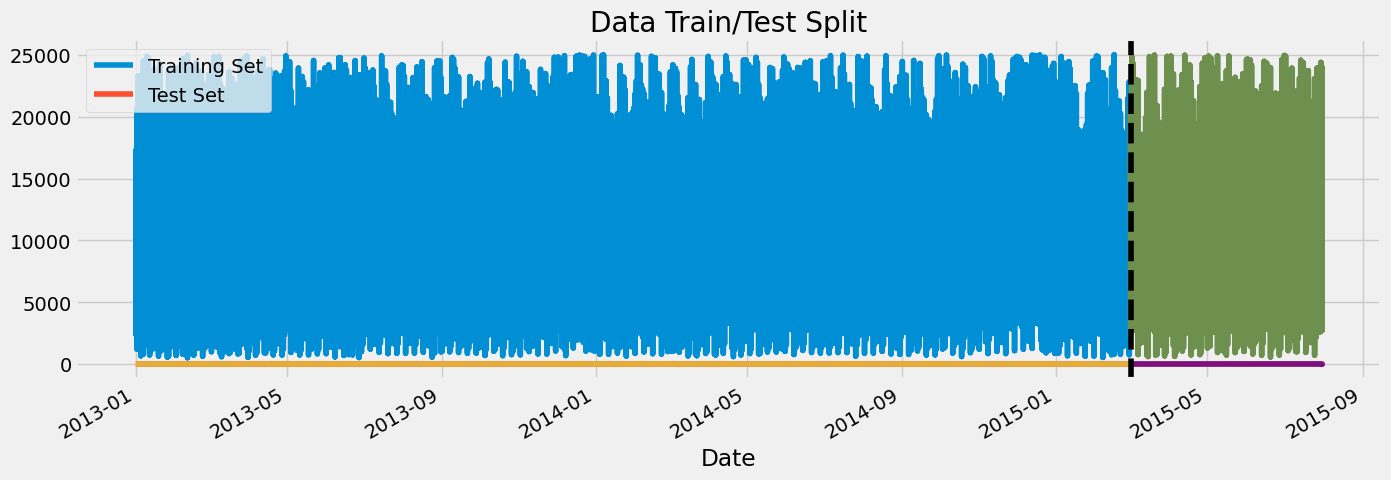

In [23]:
train = train_.loc[train_.index < '2015-03-01']
test = train_.loc[train_.index >= '2015-03-01']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline(pd.to_datetime('2015-03-01'), color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()


## Time Series Cross Validation

In [27]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=5, test_size=90, gap=1)
train_ = train_.sort_index()



In [28]:
daily_sales = train_.groupby('Date')['Sales'].sum().sort_index()


In [34]:
#train_idx

In [33]:
#val_idx

array([852, 853, 854, 855, 856, 857, 858, 859, 860, 861, 862, 863, 864,
       865, 866, 867, 868, 869, 870, 871, 872, 873, 874, 875, 876, 877,
       878, 879, 880, 881, 882, 883, 884, 885, 886, 887, 888, 889, 890,
       891, 892, 893, 894, 895, 896, 897, 898, 899, 900, 901, 902, 903,
       904, 905, 906, 907, 908, 909, 910, 911, 912, 913, 914, 915, 916,
       917, 918, 919, 920, 921, 922, 923, 924, 925, 926, 927, 928, 929,
       930, 931, 932, 933, 934, 935, 936, 937, 938, 939, 940, 941])

In [164]:
print("Daily sales length:", len(daily_sales))


Daily sales length: 942


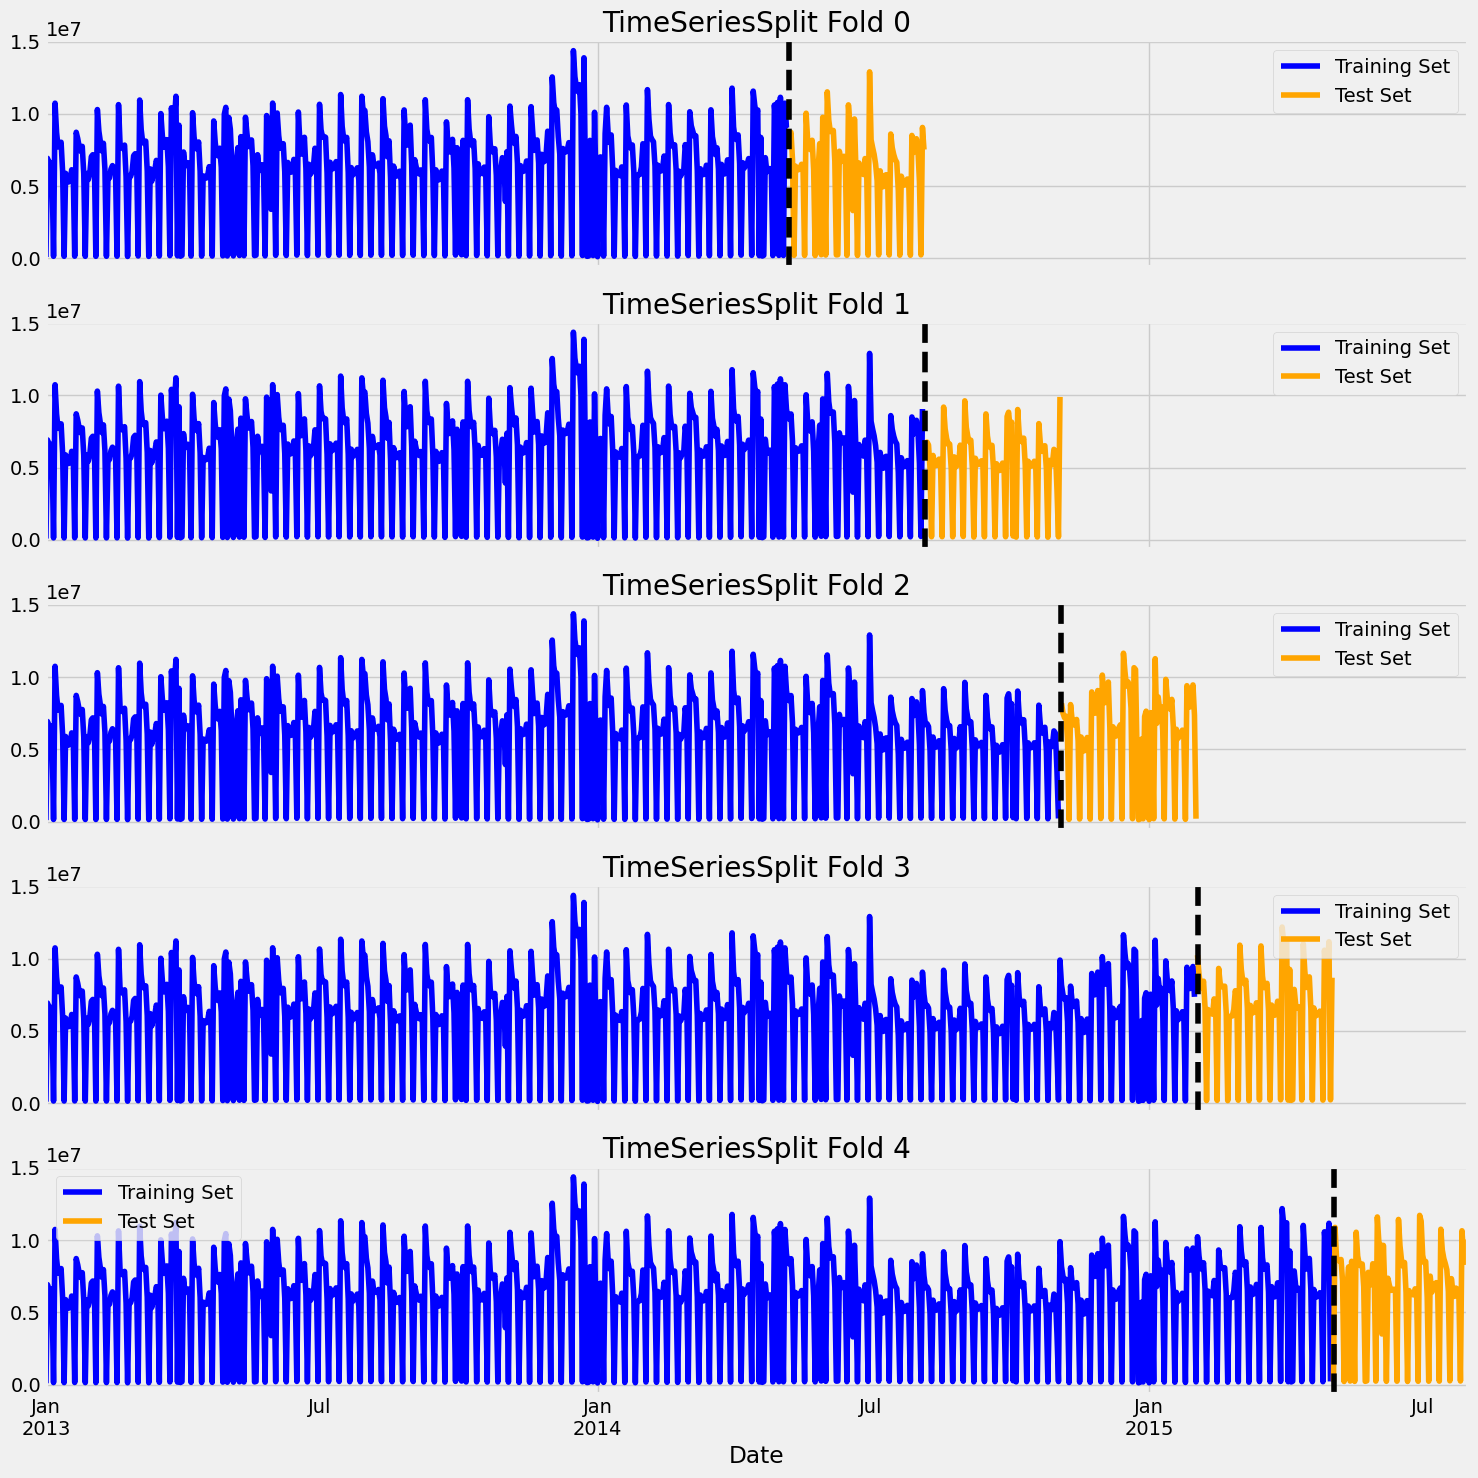

In [31]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

for fold, (train_idx, val_idx) in enumerate(tss.split(daily_sales)):
    train_fold = daily_sales.iloc[train_idx]
    test_fold = daily_sales.iloc[val_idx]
    
    train_fold.plot(ax=axs[fold], label='Training Set', color='blue')
    test_fold.plot(ax=axs[fold], label='Test Set', color='orange')
    
    axs[fold].axvline(test_fold.index.min(), color='black', ls='--')
    axs[fold].legend()
    axs[fold].set_title(f'TimeSeriesSplit Fold {fold}')

plt.tight_layout()
plt.show()


## 📈 Forecasting Horizon Explained
The forecast horizon refers to the length of time into the future for which predictions are generated. In the Rossmann Store Sales challenge, the goal is to forecast daily sales for each store over a period of 6 weeks (i.e., 42 days) into the future.

In [35]:
def create_features(train_):
    """
    Create time series features based on time series index.
    """
    train_ = train_.copy()
    train_['dayofweek'] = train_.index.dayofweek
    train_['quarter'] = train_.index.quarter
    train_['month'] = train_.index.month
    train_['year'] = train_.index.year
    train_['dayofyear'] = train_.index.dayofyear
    train_['dayofmonth'] = train_.index.day
    train_['weekofyear'] = train_.index.isocalendar().week
    return train_

train_ = create_features(train_)

## Lag Features

In [36]:
def add_lags(train_):
    target_map = train_['Sales'].to_dict()
    train_['lag1'] = (train_.index - pd.Timedelta('364 days')).map(target_map)
    return train_



In [37]:
train_ = add_lags(train_)

In [38]:
train_

,Sales,Promo,StateHoliday,SchoolHoliday,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1
Date,,,,,,,,,,,,
2013-01-01,5961,0,a,1,1,1,1,2013,1,1,1,NaN
2013-01-01,4220,0,a,1,1,1,1,2013,1,1,1,NaN
2013-01-01,6851,0,a,1,1,1,1,2013,1,1,1,NaN
2013-01-01,17267,0,a,1,1,1,1,2013,1,1,1,NaN
2013-01-01,3102,0,a,1,1,1,1,2013,1,1,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2015-07-31,8363,1,0,1,4,3,7,2015,212,31,31,3855.0
2015-07-31,9082,1,0,1,4,3,7,2015,212,31,31,3855.0
2015-07-31,10708,1,0,1,4,3,7,2015,212,31,31,3855.0


## Train Using Cross Validation

In [39]:
import xgboost as xgb

tss = TimeSeriesSplit(n_splits=5, test_size=90, gap=1)

train_ = train_.sort_index()


fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(train_):
    train = train_.iloc[train_idx]
    test = train_.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['Promo','SchoolHoliday',
                'dayofweek', 'quarter', 'month', 'year',
                'dayofyear', 'dayofmonth',  'lag1']
    TARGET = 'Sales'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[0]	validation_0-rmse:7506.08357	validation_1-rmse:8783.61341


C:\Users\win-10\AppData\Roaming\Python\Python39\site-packages\xgboost\core.py:158: UserWarning: [12:36:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:3731.84792	validation_1-rmse:4129.29028
[200]	validation_0-rmse:2857.58149	validation_1-rmse:2717.82495
[300]	validation_0-rmse:2706.77848	validation_1-rmse:2409.89834
[400]	validation_0-rmse:2677.42933	validation_1-rmse:2362.97634
[500]	validation_0-rmse:2667.47932	validation_1-rmse:2361.12860
[516]	validation_0-rmse:2666.42639	validation_1-rmse:2361.90646
[0]	validation_0-rmse:7506.22637	validation_1-rmse:9460.88669


C:\Users\win-10\AppData\Roaming\Python\Python39\site-packages\xgboost\core.py:158: UserWarning: [12:37:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:3731.87410	validation_1-rmse:4872.62376
[200]	validation_0-rmse:2857.60021	validation_1-rmse:3439.63703
[300]	validation_0-rmse:2706.94116	validation_1-rmse:3040.66081
[400]	validation_0-rmse:2677.56381	validation_1-rmse:2934.13471
[500]	validation_0-rmse:2667.58998	validation_1-rmse:2901.56959
[600]	validation_0-rmse:2662.10407	validation_1-rmse:2877.69667
[700]	validation_0-rmse:2658.23190	validation_1-rmse:2867.22873
[800]	validation_0-rmse:2655.64201	validation_1-rmse:2860.33086
[900]	validation_0-rmse:2653.67219	validation_1-rmse:2858.12355
[999]	validation_0-rmse:2652.06409	validation_1-rmse:2856.86925
[0]	validation_0-rmse:7506.46249	validation_1-rmse:9681.97674


C:\Users\win-10\AppData\Roaming\Python\Python39\site-packages\xgboost\core.py:158: UserWarning: [12:38:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:3731.96421	validation_1-rmse:5150.50120
[200]	validation_0-rmse:2857.61941	validation_1-rmse:3741.66295
[300]	validation_0-rmse:2706.82433	validation_1-rmse:3347.81135
[400]	validation_0-rmse:2677.46170	validation_1-rmse:3236.19139
[500]	validation_0-rmse:2667.53515	validation_1-rmse:3194.79034
[600]	validation_0-rmse:2662.08492	validation_1-rmse:3170.18933
[700]	validation_0-rmse:2658.42558	validation_1-rmse:3158.20384
[800]	validation_0-rmse:2655.74827	validation_1-rmse:3145.85629
[900]	validation_0-rmse:2653.82169	validation_1-rmse:3143.07647
[999]	validation_0-rmse:2652.11184	validation_1-rmse:3141.54666
[0]	validation_0-rmse:7506.73050	validation_1-rmse:9129.94621


C:\Users\win-10\AppData\Roaming\Python\Python39\site-packages\xgboost\core.py:158: UserWarning: [12:38:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:3732.08562	validation_1-rmse:4715.50947
[200]	validation_0-rmse:2857.68480	validation_1-rmse:3503.82404
[300]	validation_0-rmse:2706.81322	validation_1-rmse:3245.22239
[400]	validation_0-rmse:2677.67407	validation_1-rmse:3200.66996
[500]	validation_0-rmse:2667.69078	validation_1-rmse:3195.01990
[544]	validation_0-rmse:2665.04393	validation_1-rmse:3196.03895
[0]	validation_0-rmse:7506.91538	validation_1-rmse:9841.21944


C:\Users\win-10\AppData\Roaming\Python\Python39\site-packages\xgboost\core.py:158: UserWarning: [12:39:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:3732.18163	validation_1-rmse:5292.94560
[200]	validation_0-rmse:2857.75939	validation_1-rmse:3869.72813
[300]	validation_0-rmse:2706.98390	validation_1-rmse:3448.53001
[400]	validation_0-rmse:2677.71257	validation_1-rmse:3323.69439
[500]	validation_0-rmse:2667.73896	validation_1-rmse:3275.45789
[600]	validation_0-rmse:2662.25515	validation_1-rmse:3245.94930
[700]	validation_0-rmse:2658.40599	validation_1-rmse:3230.15634
[800]	validation_0-rmse:2655.80384	validation_1-rmse:3216.90286
[900]	validation_0-rmse:2653.86054	validation_1-rmse:3211.89350
[999]	validation_0-rmse:2652.16721	validation_1-rmse:3208.22883


In [40]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 2952.3472
Fold scores:[np.float64(2360.1623884809283), np.float64(2856.860514620901), np.float64(3141.514921180544), np.float64(3195.0082941989367), np.float64(3208.18998813973)]


## Predicting the Future¶
  Retraining on all data
  
  To Predict the future we need an emtpy dataframe for future date ranges.
  
  Run those dates through our feature creation code + lag creation
  

In [41]:
# Retrain on all data
train_ = create_features(train_)

FEATURES = ['Promo','SchoolHoliday',
                'dayofweek', 'quarter', 'month', 'year',
                'dayofyear', 'dayofmonth',  'lag1']
TARGET = 'Sales'

X_all = train_[FEATURES]
y_all = train_[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=500,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[0]	validation_0-rmse:7507.20452


C:\Users\win-10\AppData\Roaming\Python\Python39\site-packages\xgboost\core.py:158: UserWarning: [12:42:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:3732.30815
[200]	validation_0-rmse:2857.84262
[300]	validation_0-rmse:2707.02830
[400]	validation_0-rmse:2677.75927
[499]	validation_0-rmse:2667.91085


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

In [42]:
train_.index.max()

Timestamp('2015-07-31 00:00:00')

In [43]:
# Define forecast horizon: 6 weeks ahead, daily frequency
forecast_horizon = 42  # days

# Get the last date in your training data
last_date = train_.index.max()

# Create future dates starting the day after last training date
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), 
                             periods=forecast_horizon, 
                             freq='D')

# Create future dataframe
future_df = pd.DataFrame(index=future_dates)
future_df['isFuture'] = True

# Mark historical data
train_ = train_.copy()
train_['isFuture'] = False

# Combine
combined_df = pd.concat([train_, future_df])

# Add features
combined_df = create_features(combined_df)

# Add lags
combined_df = add_lags(combined_df)


In [47]:
combined_df

,Sales,Promo,StateHoliday,SchoolHoliday,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,isFuture
2013-01-01,5961.0,0.0,a,1.0,1,1,1,2013,1,1,1,NaN,False
2013-01-01,4220.0,0.0,a,1.0,1,1,1,2013,1,1,1,NaN,False
2013-01-01,6851.0,0.0,a,1.0,1,1,1,2013,1,1,1,NaN,False
2013-01-01,17267.0,0.0,a,1.0,1,1,1,2013,1,1,1,NaN,False
2013-01-01,3102.0,0.0,a,1.0,1,1,1,2013,1,1,1,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-09-07,NaN,NaN,NaN,NaN,0,3,9,2015,250,7,37,4970.0,True
2015-09-08,NaN,NaN,NaN,NaN,1,3,9,2015,251,8,37,5077.0,True
2015-09-09,NaN,NaN,NaN,NaN,2,3,9,2015,252,9,37,4290.0,True
2015-09-10,NaN,NaN,NaN,NaN,3,3,9,2015,253,10,37,3879.0,True


In [44]:
future_w_features = combined_df.query('isFuture').copy()

##  Predict the future

In [45]:
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

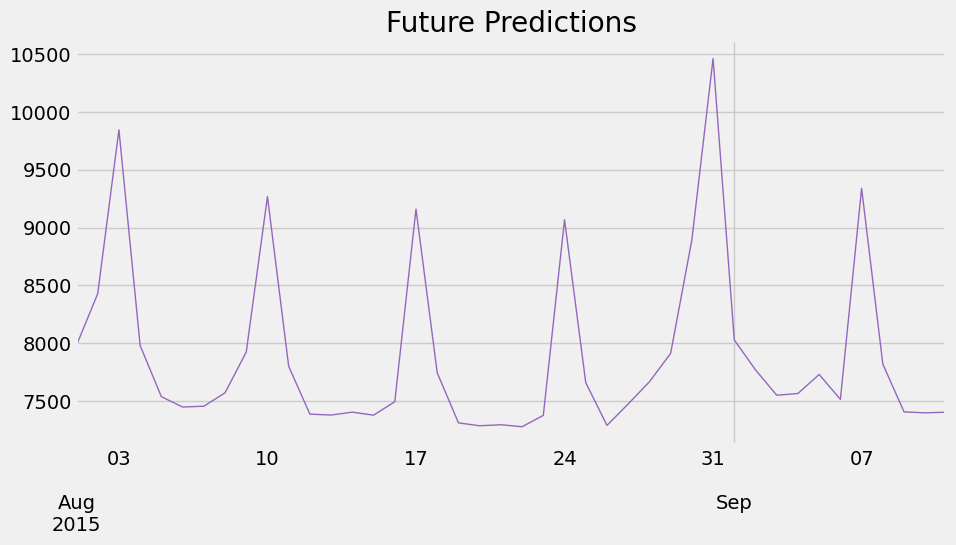

In [46]:
future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[4],
                               ms=1,
                               lw=1,
                               title='Future Predictions')
plt.show()